In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
data_train = pd.read_csv('./fashion-mnist_train.csv')
X_full = data_train.iloc[:,1:]
y_full = data_train.iloc[:,:1]
x_train, x_test, y_train, y_test = train_test_split(X_full, y_full, test_size
= 0.2)

In [3]:
x_train = x_train.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
x_test = x_test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.
y_train = y_train.values.astype('int')
y_test = y_test.values.astype('int')
print('Training', x_train.shape, x_train.max())
print('Testing', x_test.shape, x_test.max())

Training (48000, 28, 28, 1) 1.0
Testing (12000, 28, 28, 1) 1.0


In [4]:
# reorganize by groups
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4833, 4839, 4824, 4813, 4777, 4793, 4740, 4848, 4812, 4721]
test groups: [1167, 1161, 1176, 1187, 1223, 1207, 1260, 1152, 1188, 1279]


In [5]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

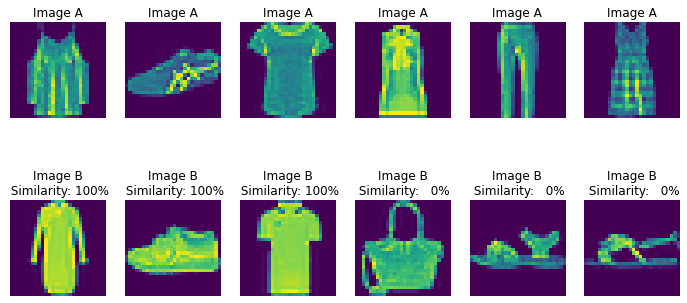

In [6]:
pv_a, pv_b, pv_sim = gen_random_batch(train_groups, 3)
fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize=(12, 6))
for c_a, c_b, c_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, m_axs.T):
    ax1.imshow(c_a[:,:,0])
    ax1.set_title('Image A')
    ax1.axis('off')
    ax2.imshow(c_b[:,:,0])
    ax2.set_title('Image B\n Similarity: %3.0f%%' % (100*c_d))
    ax2.axis('off')

In [7]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='InceptionV1Input')
n_layer = img_in

layer_1 = Conv2D(64, (1,1), padding='same', activation='relu')(n_layer)
layer_1 = Conv2D(64, (3,3), padding='same', activation='relu')(layer_1)
layer_2 = Conv2D(64, (1,1), padding='same', activation='relu')(n_layer)
layer_2 = Conv2D(64, (5,5), padding='same', activation='relu')(layer_2)
layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(n_layer)
layer_3 = Conv2D(64, (1,1), padding='same', activation='relu')(layer_3)

output = keras.layers.concatenate([layer_1, layer_2, layer_3], axis = 3)
output = Flatten()(output)
out = Dense(10, activation='relu')(output)

feature_model = Model(inputs=[img_in], outputs=[out], name='InceptionV1Model')
feature_model.summary()

Model: "InceptionV1Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 InceptionV1Input (InputLayer)  [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 64)   128         ['InceptionV1Input[0][0]']       
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 64)   128         ['InceptionV1Input[0][0]']       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 1)    0           ['InceptionV1Input[0][0]']       
                                                                                   

2022-04-25 10:45:34.176392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageA_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 ImageB_Input (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 InceptionV1Model (Functional)  (None, 10)           1645066     ['ImageA_Input[0][0]',           
                                                                  'ImageB_Input[0][0]']           
                                                                                                  
 merge_features (Concatenate)   (None, 20)           0           ['InceptionV1Model

In [9]:
# setup the optimization process
similarity_model.compile(optimizer='adam', loss = 'binary_crossentropy',
metrics = ['mae'])

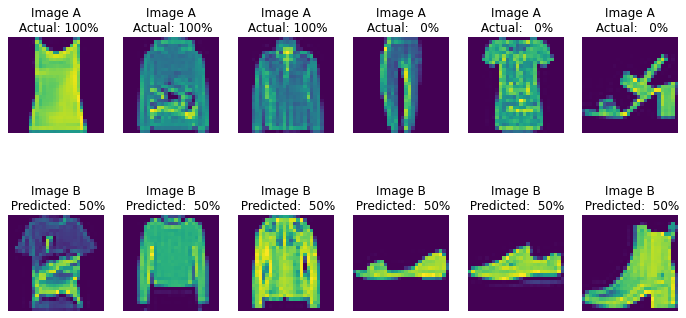

In [10]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig
# a completely untrained model
_ = show_model_output()



In [11]:
# make a generator out of the data
def siam_gen(in_groups, batch_size = 32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(in_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim
# we want a constant validation group to have a frame of reference for model performance
valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit_generator(siam_gen(train_groups),
                                              steps_per_epoch = 500,
                                              validation_data=([valid_a, valid_b],valid_sim),
                                            epochs = 10,
                                            verbose = True)

/var/folders/vc/r_1rgyfx0_d7pn7f0bpt_str0000gp/T/ipykernel_58195/1031500842.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = similarity_model.fit_generator(siam_gen(train_groups),


Epoch 1/10
500/500 [==============================] - 144s 285ms/step - loss: 0.4944 - mae: 0.3582 - val_loss: 0.4222 - val_mae: 0.2860
Epoch 2/10
500/500 [==============================] - 137s 274ms/step - loss: 0.3740 - mae: 0.2551 - val_loss: 0.3746 - val_mae: 0.2503
Epoch 3/10
500/500 [==============================] - 135s 271ms/step - loss: 0.3331 - mae: 0.2182 - val_loss: 0.3040 - val_mae: 0.1977
Epoch 4/10
500/500 [==============================] - 140s 279ms/step - loss: 0.3062 - mae: 0.1975 - val_loss: 0.2946 - val_mae: 0.1806
Epoch 5/10
500/500 [==============================] - 136s 271ms/step - loss: 0.2817 - mae: 0.1782 - val_loss: 0.2747 - val_mae: 0.1706
Epoch 6/10
500/500 [==============================] - 135s 271ms/step - loss: 0.2854 - mae: 0.1797 - val_loss: 0.2845 - val_mae: 0.1928
Epoch 7/10
500/500 [==============================] - 133s 266ms/step - loss: 0.2720 - mae: 0.1707 - val_loss: 0.2777 - val_mae: 0.1722
Epoch 8/10
500/500 [============================

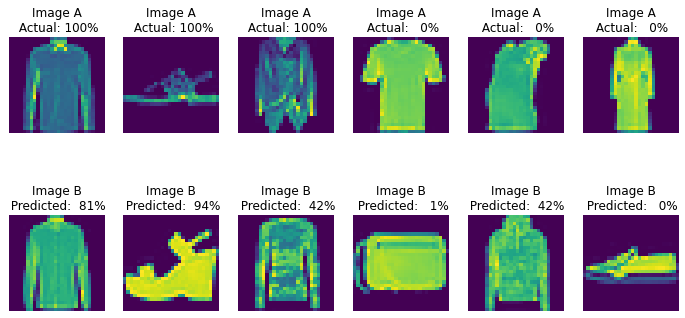

In [12]:
_ = show_model_output()

In [13]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0],0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose =
True, batch_size = 128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0],0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose
= True, batch_size = 128)

94/94 [==============================] - 23s 246ms/step


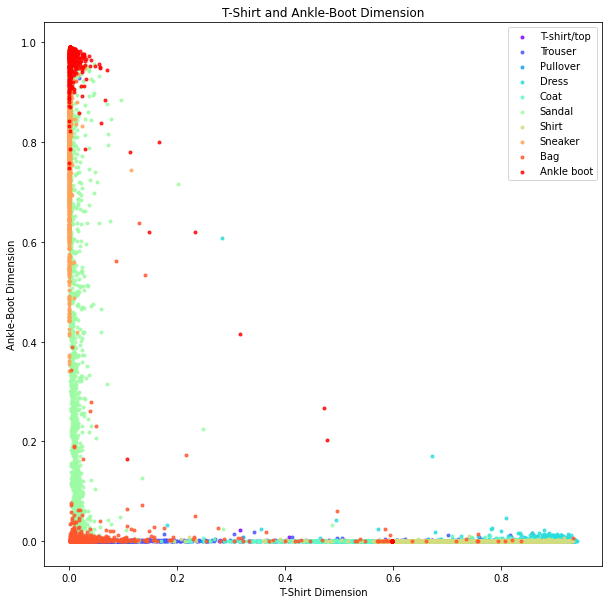

In [17]:
obj_categories = [
    'T-shirt/top','Trouser','Pullover','Dress',
    'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.savefig('tshirt-boot-dist.png')
plt.show(block=False)

In [18]:
x_test_features = feature_model.predict(x_test, verbose = True,batch_size=128)

94/94 [==============================] - 11s 114ms/step


In [19]:
%%time
from sklearn.manifold import TSNE
tsne_obj = TSNE(n_components=2,
            init='pca',
            random_state=101,
            method='barnes_hut',
            n_iter=500,
            verbose=2)
tsne_features = tsne_obj.fit_transform(x_test_features)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.010s...
[t-SNE] Computed neighbors for 12000 samples in 0.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 3.734528
[t-SNE] Computed cond

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 60.9543076, gradient norm = 0.0168464 (50 iterations in 1.418s)
[t-SNE] Iteration 100: error = 65.2977295, gradient norm = 0.0098180 (50 iterations in 1.211s)
[t-SNE] Iteration 150: error = 67.8740234, gradient norm = 0.0047747 (50 iterations in 1.259s)
[t-SNE] Iteration 200: error = 69.3099899, gradient norm = 0.0053986 (50 iterations in 1.213s)
[t-SNE] Iteration 250: error = 70.4395447, gradient norm = 0.0044466 (50 iterations in 1.249s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.439545
[t-SNE] Iteration 300: error = 1.9592371, gradient norm = 0.0010116 (50 iterations in 1.372s)
[t-SNE] Iteration 350: error = 1.6885604, gradient norm = 0.0004165 (50 iterations in 1.288s)
[t-SNE] Iteration 400: error = 1.5860860, gradient norm = 0.0002504 (50 iterations in 1.301s)
[t-SNE] Iteration 450: error = 1.5253203, gradient norm = 0.0001774 (50 iterations in 1.368s)
[t-SNE] Iteration 500: error = 1.4859376, gradient norm = 0.0001345 (50 

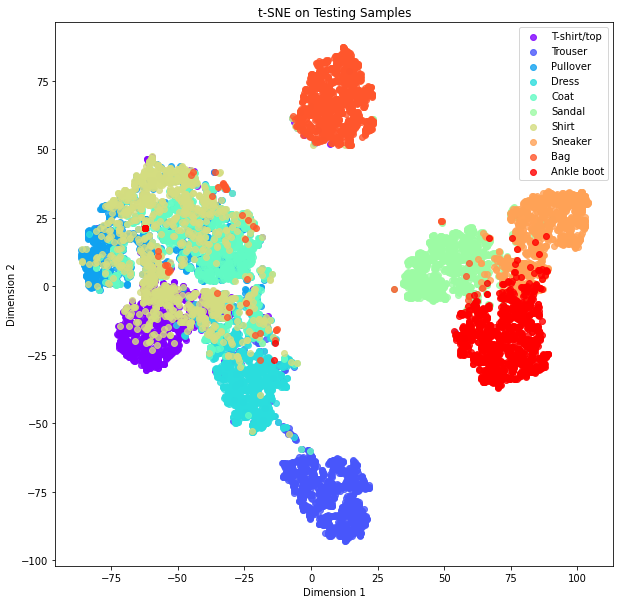

In [22]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress',
'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'
]
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

